# A4 Keqi Liao

# Read data

In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()
import matplotlib.pyplot as plt
from pyspark.sql.functions import col,sum as spark_sum, count, desc,expr,when
from pyspark.sql.functions import mean
import seaborn as sns
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import percentile_approx

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 14:27:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/home/ubuntu/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = spark.read.csv('water_potability.csv', header=True, inferSchema=True)

In [3]:
df.printSchema()

root
 |-- ph: double (nullable = true)
 |-- Hardness: double (nullable = true)
 |-- Solids: double (nullable = true)
 |-- Chloramines: double (nullable = true)
 |-- Sulfate: double (nullable = true)
 |-- Conductivity: double (nullable = true)
 |-- Organic_carbon: double (nullable = true)
 |-- Trihalomethanes: double (nullable = true)
 |-- Turbidity: double (nullable = true)
 |-- Potability: integer (nullable = true)



In [4]:
df.show(n=5)

+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+
|               ph|          Hardness|            Solids|      Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|
+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+
|             null| 204.8904554713363|20791.318980747026|7.300211873184757|368.51644134980336| 564.3086541722439|  10.3797830780847|  86.9909704615088|2.9631353806316407|         0|
| 3.71608007538699|129.42292051494425|18630.057857970347|   6.635245883862|              null| 592.8853591348523|15.180013116357259| 56.32907628451764| 4.500656274942408|         0|
|8.099124189298397|224.23625939355776|19909.541732292393|9.275883602694089|              n

In [5]:
df.count()

3276

In [6]:
df.summary().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|summary|                ph|          Hardness|            Solids|       Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|         Potability|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|  count|              2785|              3276|              3276|              3276|              2495|              3276|              3276|              3114|              3276|               3276|
|   mean| 7.080794504276819|196.36949601730177| 22014.09252607711| 7.122276793425787| 333.7757766108134| 426.2051106825521|14.284970247677341| 66.39629294676803|3.9667861697910576| 0.3901098901098

# Data visialization

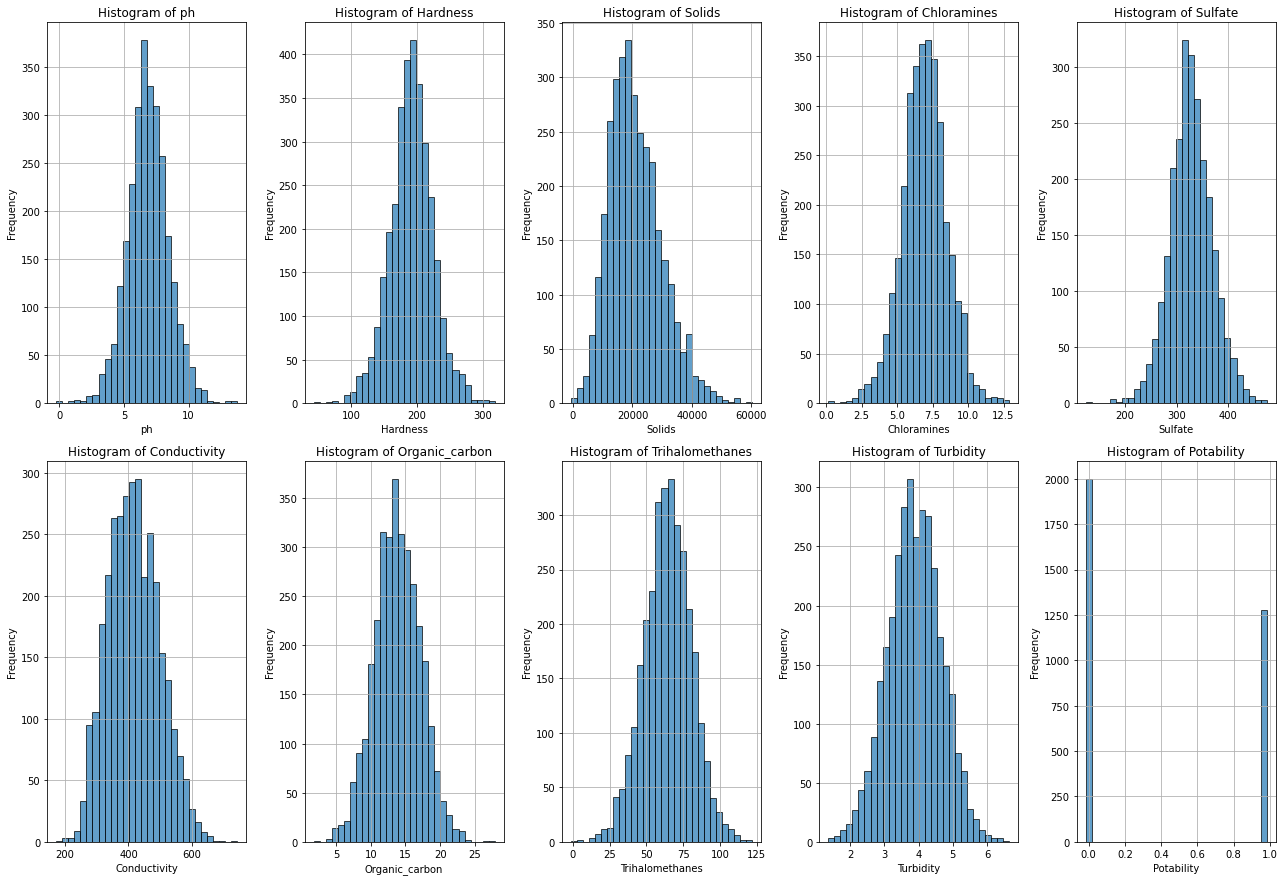

In [7]:
columns_to_plot = [
    'ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 
    'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'
]

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(18, 18))
axes = axes.flatten()

for idx, column in enumerate(columns_to_plot):

    df_clean = df.select(col(column).cast("float"))

    histogram_data = df_clean.rdd.flatMap(lambda x: x).histogram(30)
    bins = histogram_data[0]
    counts = histogram_data[1]

    axes[idx].bar(bins[:-1], counts, width=bins[1] - bins[0], edgecolor='k', alpha=0.7)
    axes[idx].set_title(f'Histogram of {column}')
    axes[idx].set_xlabel(column)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True)

for i in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

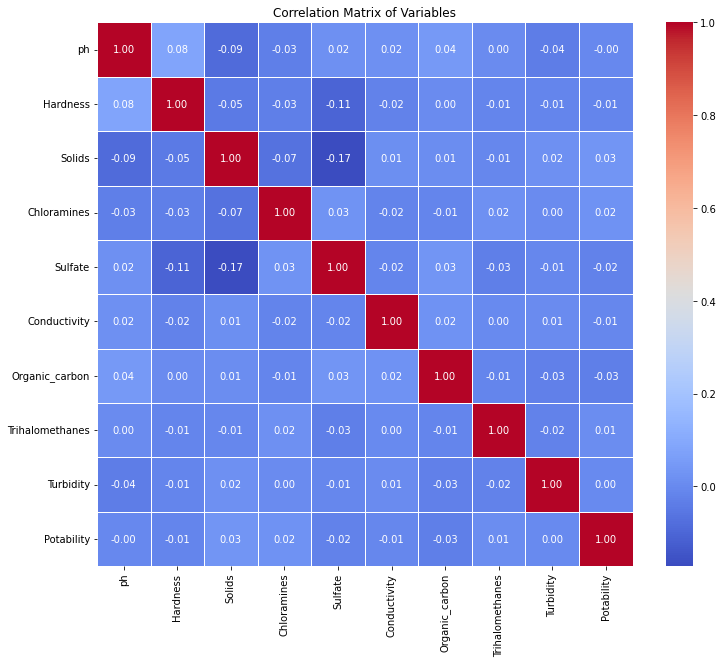

In [8]:
df_clean = df.select([col(column).cast("float") for column in columns_to_plot])

pandas_df = df_clean.toPandas()

correlation_matrix = pandas_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Variables')
plt.show()

# Missing value

In [9]:
# Count missing values in each column
missing_counts = df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in columns_to_plot])

# Show missing counts
missing_counts.show()

# Convert to Pandas DataFrame for better visualization
missing_counts_pd = missing_counts.toPandas()
print(missing_counts_pd)

+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
| ph|Hardness|Solids|Chloramines|Sulfate|Conductivity|Organic_carbon|Trihalomethanes|Turbidity|Potability|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
|491|       0|     0|          0|    781|           0|             0|            162|        0|         0|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+

    ph  Hardness  Solids  Chloramines  Sulfate  Conductivity  Organic_carbon  \
0  491         0       0            0      781             0               0   

   Trihalomethanes  Turbidity  Potability  
0              162          0           0  


# Outliers

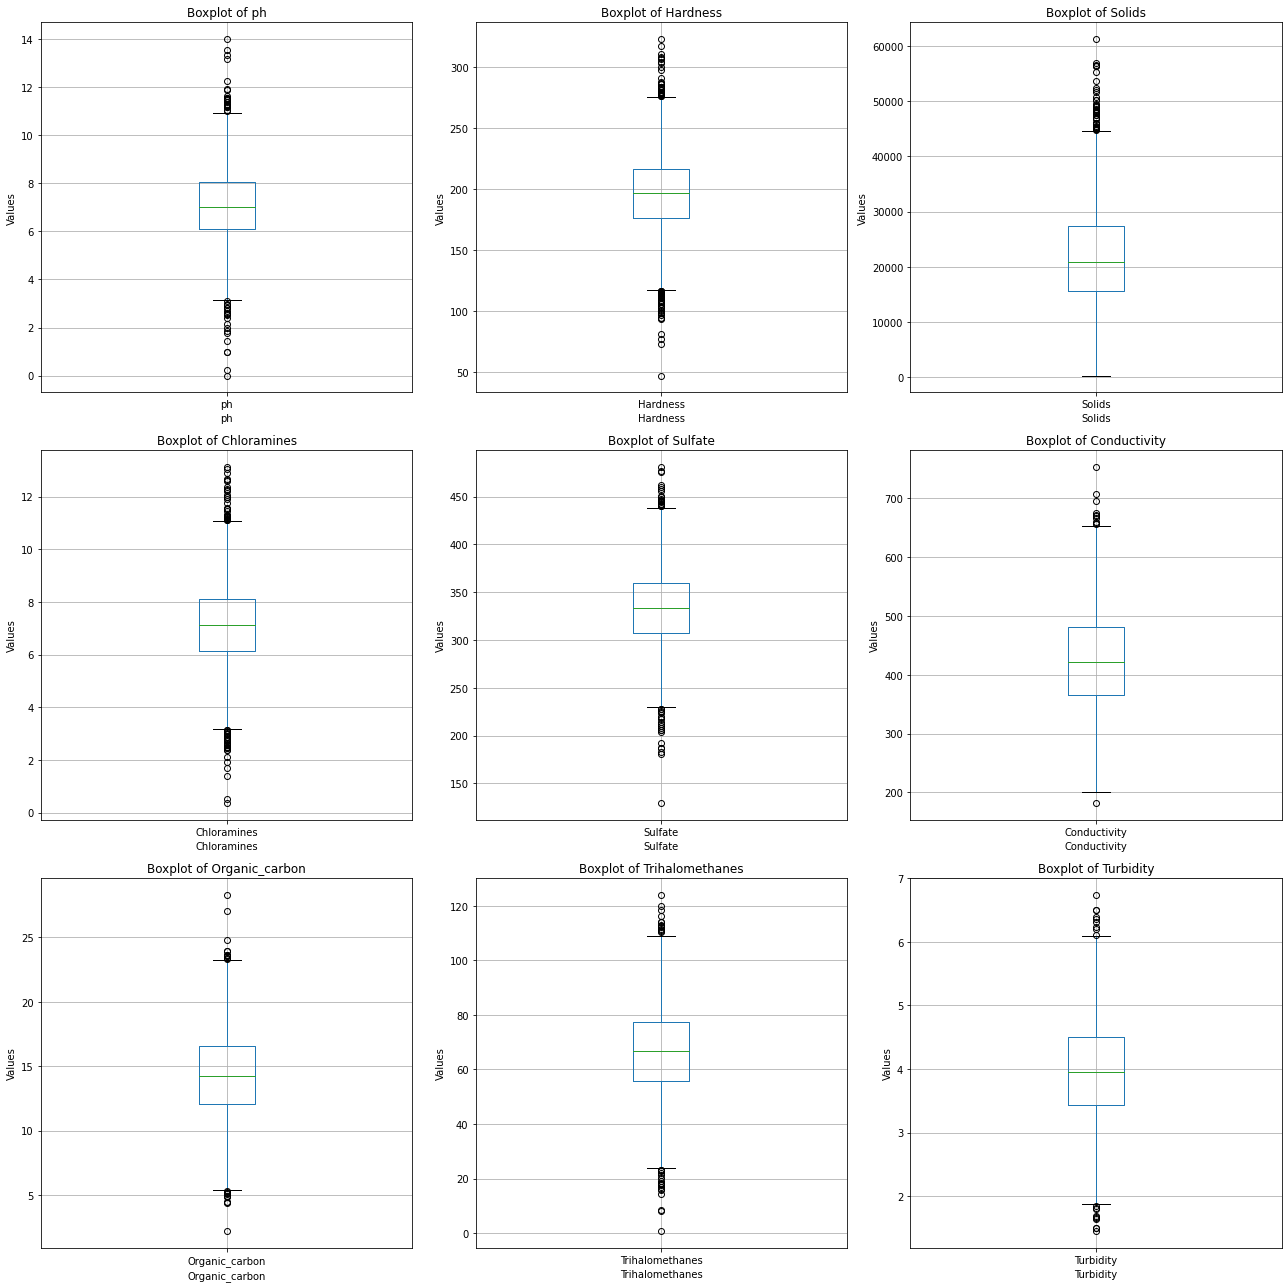

In [10]:
columns_to_plot2 = [
    'ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 
    'Organic_carbon', 'Trihalomethanes', 'Turbidity']

df_clean = df.select([col(column).cast("float") for column in columns_to_plot2])

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 18))

axes = axes.flatten()

for idx, column in enumerate(columns_to_plot2):
    pandas_df.boxplot(column=column, ax =axes[idx])

    axes[idx].set_title(f'Boxplot of {column}')
    axes[idx].set_xlabel(column)
    axes[idx].set_ylabel('Values')
    axes[idx].grid(True)

for i in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Dealing with missing value

In [11]:
mean_val = df.select(mean(col('Sulfate'))).collect()[0][0]
df_filled = df.na.fill(mean_val, ['Sulfate'])

median_val = df_filled.select(percentile_approx(col('ph'), 0.5).alias('median')).collect()
median = median_val[0][0]
df_filled_2 = df_filled.na.fill(median, ['ph'])

median_val2 = df_filled.select(percentile_approx(col('Trihalomethanes'), 0.5).alias('median')).collect()
median_val2 = median_val2[0][0]
df_filled_3 = df_filled_2.na.fill(median_val2, ['Trihalomethanes'])


In [12]:
missing_counts = df_filled_3.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in columns_to_plot])
missing_counts.show()

+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
| ph|Hardness|Solids|Chloramines|Sulfate|Conductivity|Organic_carbon|Trihalomethanes|Turbidity|Potability|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
|  0|       0|     0|          0|      0|           0|             0|              0|        0|         0|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+



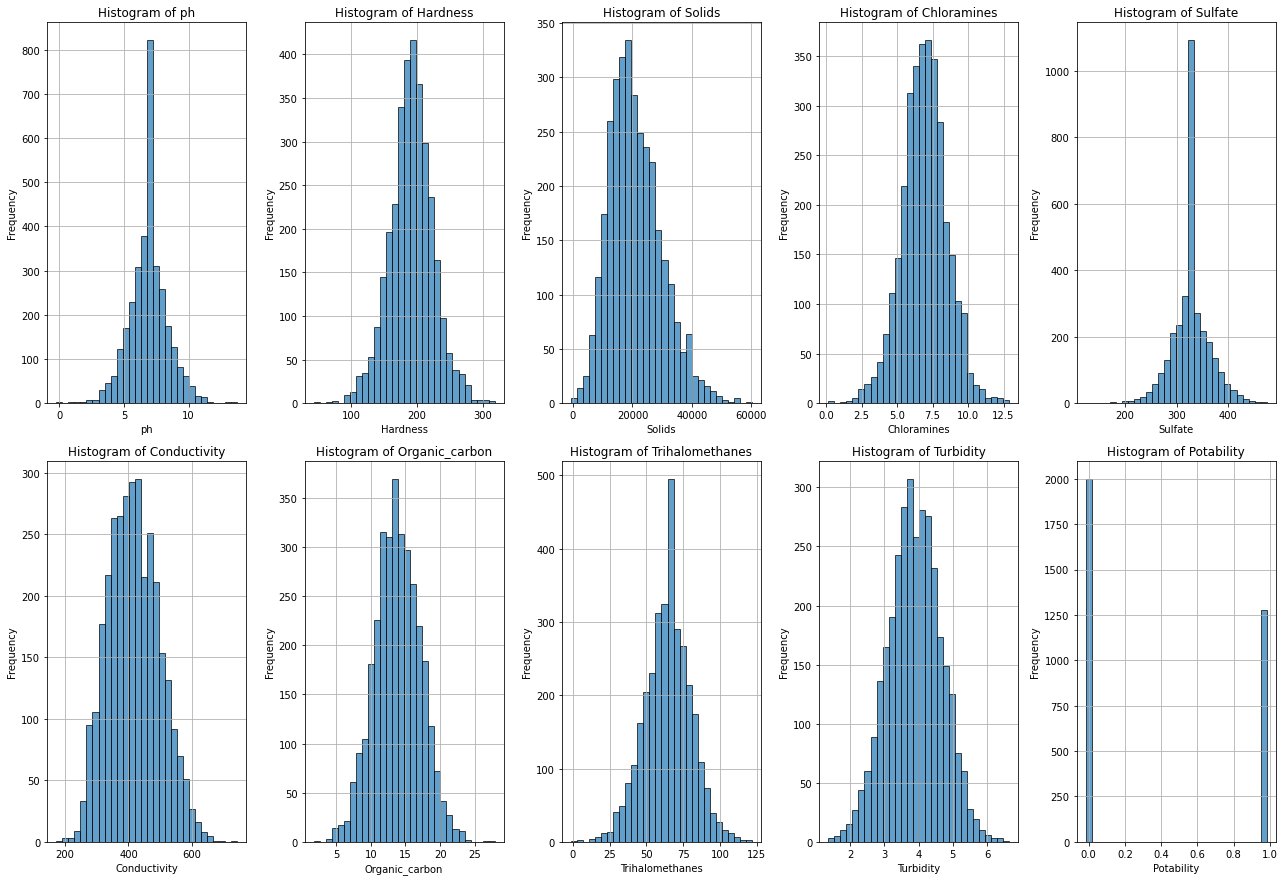

In [13]:

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(18, 18))
axes = axes.flatten()

for idx, column in enumerate(columns_to_plot):

    df_clean = df_filled_3.select(col(column).cast("float"))

    histogram_data = df_clean.rdd.flatMap(lambda x: x).histogram(30)
    bins = histogram_data[0]
    counts = histogram_data[1]

    axes[idx].bar(bins[:-1], counts, width=bins[1] - bins[0], edgecolor='k', alpha=0.7)
    axes[idx].set_title(f'Histogram of {column}')
    axes[idx].set_xlabel(column)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True)

for i in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Deal with outliers

In [14]:
from pyspark.sql.functions import stddev
from pyspark.sql.types import DoubleType

z_score_threshold = 3

def calculate_z_scores_and_filter(df, z_score_threshold):
    numeric_columns = [c for c, dtype in df.dtypes if dtype in ('int', 'double', 'float')]
    stats = df.select([mean(col(c)).alias(c + '_mean') for c in numeric_columns] + 
                      [stddev(col(c)).alias(c + '_stddev') for c in numeric_columns]).collect()[0]
    
    z_score_cols = [(col(c) - stats[c + '_mean']) / stats[c + '_stddev'] for c in numeric_columns]
    for i, c in enumerate(numeric_columns):
        df = df.withColumn(c + '_z', z_score_cols[i])
    
    condition = ' or '.join([f"abs({c}_z) > {z_score_threshold}" for c in numeric_columns])
    df_no_outliers = df.filter(f"not ({condition})")

    z_score_columns = [c + '_z' for c in numeric_columns]
    df_no_outliers = df_no_outliers.drop(*z_score_columns)
    
    return df_no_outliers

df_no_outliers = calculate_z_scores_and_filter(df_filled_3, z_score_threshold)
df_no_outliers.show(5)

24/05/23 14:28:25 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+
|               ph|          Hardness|            Solids|      Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|
+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+
|7.036752103833548| 204.8904554713363|20791.318980747026|7.300211873184757|368.51644134980336| 564.3086541722439|  10.3797830780847|  86.9909704615088|2.9631353806316407|         0|
| 3.71608007538699|129.42292051494425|18630.057857970347|   6.635245883862| 333.7757766108134| 592.8853591348523|15.180013116357259| 56.32907628451764| 4.500656274942408|         0|
|8.099124189298397|224.23625939355776|19909.541732292393|9.275883602694089| 333.7757766108

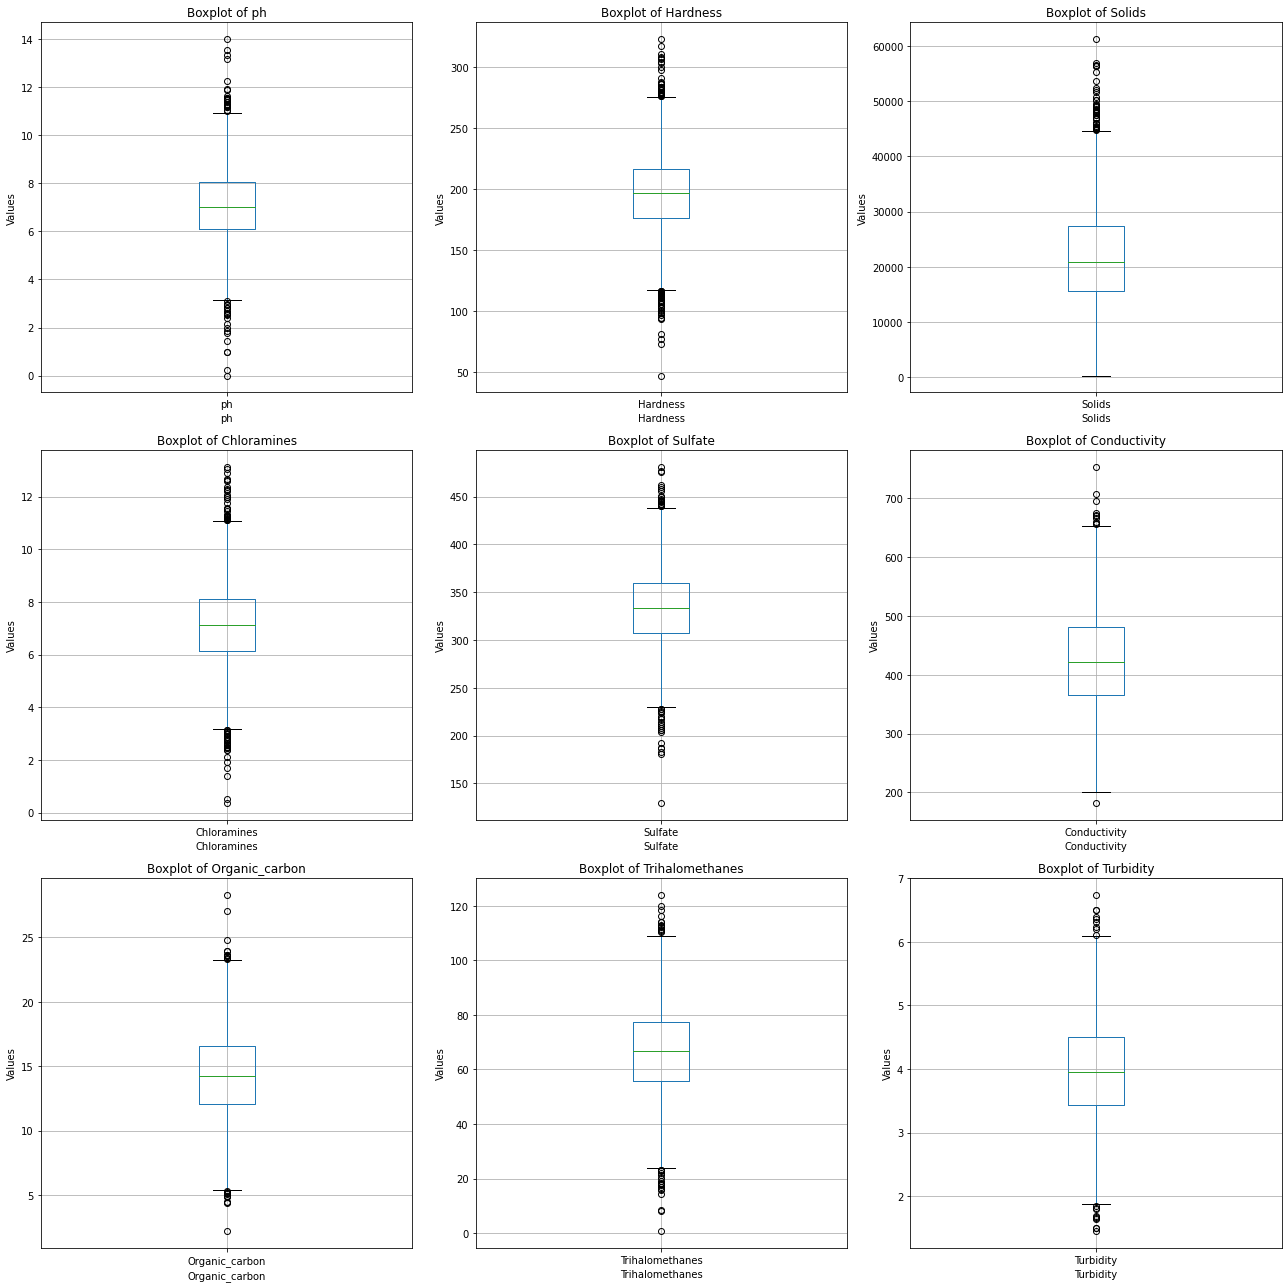

In [15]:
df_clean = df_no_outliers.select([col(column).cast("float") for column in columns_to_plot2])

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 18))

axes = axes.flatten()

for idx, column in enumerate(columns_to_plot2):
    pandas_df.boxplot(column=column, ax =axes[idx])

    axes[idx].set_title(f'Boxplot of {column}')
    axes[idx].set_xlabel(column)
    axes[idx].set_ylabel('Values')
    axes[idx].grid(True)

for i in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Constructing a New Feature

In [16]:
df_new = df_no_outliers.withColumn("pH_Category", 
    when(col("ph") < 5.0, "Very Acidic")
    .when((col("ph") >= 5.0) & (col("ph") < 6.5), "Acidic")
    .when((col("ph") >= 6.5) & (col("ph") < 7.0), "Slightly Acidic")
    .when((col("ph") >= 7.0) & (col("ph") <= 7.5), "Neutral")
    .when((col("ph") > 7.5) & (col("ph") <= 8.0), "Slightly Alkaline")
    .when((col("ph") > 8.0) & (col("ph") < 9.0), "Alkaline")
    .otherwise("Extremely Alkaline")
)

# Show the DataFrame with the new column
df_new.show(5)

+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+------------------+
|               ph|          Hardness|            Solids|      Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|       pH_Category|
+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+------------------+
|7.036752103833548| 204.8904554713363|20791.318980747026|7.300211873184757|368.51644134980336| 564.3086541722439|  10.3797830780847|  86.9909704615088|2.9631353806316407|         0|           Neutral|
| 3.71608007538699|129.42292051494425|18630.057857970347|   6.635245883862| 333.7757766108134| 592.8853591348523|15.180013116357259| 56.32907628451764| 4.500656274942408|         0|       Very Aci

# Data Integration

In [17]:
# Split the DataFrame into two parts
split_ratio = [0.5, 0.5]  # 50% split
df_1, df_2 = df_new.randomSplit(split_ratio, seed=42)

df_merged = df_1.union(df_2)

df_merged.show(5)

+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+----------+-----------+
|                ph|          Hardness|            Solids|      Chloramines|           Sulfate|      Conductivity|    Organic_carbon|  Trihalomethanes|         Turbidity|Potability|pH_Category|
+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+----------+-----------+
|2.9454690611226875|126.74810032577287|16829.393039119645|10.59739483099463| 333.7757766108134|456.23318950350614| 10.15713862348548|79.31055731576916|  5.06998277048037|         0|Very Acidic|
|3.2309731059187423|120.78544948310383|13691.094972435034|6.835951440246375|328.24028919650993| 261.4352151594753|18.406139020307307|54.85212343389985|3.2819205591698437|         0|Very Acidic|
| 3.388090610523891| 212.02894

In [18]:
# Split the DataFrame into two parts
df_part1 = df_new.select("ph", "Hardness", "Solids", "Chloramines", "Sulfate", "Potability", "Trihalomethanes")
df_part2 = df_new.select("ph", "Conductivity", "Organic_carbon", "Turbidity", "pH_Category")

df_part1.createOrReplaceTempView("Table1")
df_part2.createOrReplaceTempView("Table2")

# SQL query to merge the tables
query = """
SELECT a.ph, a.Hardness, a.Solids, a.Chloramines, a.Sulfate, b.Conductivity, b.Organic_carbon, 
a.Trihalomethanes, b.Turbidity, a.Potability, b.pH_Category
FROM Table1 a
JOIN Table2 b ON a.ph = b.ph
"""


merged_df = spark.sql(query)
merged_df.show(5)

+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+----------------+------------------+----------+-----------+
|               ph|         Hardness|            Solids|      Chloramines|           Sulfate|      Conductivity|    Organic_carbon| Trihalomethanes|         Turbidity|Potability|pH_Category|
+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+----------------+------------------+----------+-----------+
|7.036752103833548|204.8904554713363|20791.318980747026|7.300211873184757|368.51644134980336|428.21398699299374| 8.668672182023442|86.9909704615088|3.6995580484850445|         0|    Neutral|
|7.036752103833548|204.8904554713363|20791.318980747026|7.300211873184757|368.51644134980336| 555.5485339351901|16.959268901127814|86.9909704615088|   4.3316909034515|         0|    Neutral|
|7.036752103833548|204.8904554713363|20791.31

# Formatting Data

In [19]:
df_new = df_new.withColumn("Potability_new", 
    when(col("Potability") == 1, "Potable")
    .when(col("Potability") == 0, "Not_Potable")
    .otherwise("Unknown"))

# Show the DataFrame
df_new.show(5)

+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+------------------+--------------+
|               ph|          Hardness|            Solids|      Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|       pH_Category|Potability_new|
+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+----------+------------------+--------------+
|7.036752103833548| 204.8904554713363|20791.318980747026|7.300211873184757|368.51644134980336| 564.3086541722439|  10.3797830780847|  86.9909704615088|2.9631353806316407|         0|           Neutral|   Not_Potable|
| 3.71608007538699|129.42292051494425|18630.057857970347|   6.635245883862| 333.7757766108134| 592.8853591348523|15.180013116357259| 56.

# Feature Selection

In [20]:
from pyspark.sql.functions import abs as abs_func
from pyspark.sql.types import IntegerType, DoubleType
target_col = "Potability"
numeric_columns = [col for col in df_new.columns if col != target_col and df_new.schema[col].dataType in [IntegerType(), DoubleType()]]

correlations = {}
for col in numeric_columns:
    correlation = df_new.stat.corr(col, target_col)
    correlations[col] = abs(correlation)

from pyspark.sql import Row
corr_df = spark.createDataFrame([Row(column=col, correlation=corr_value) for col, corr_value in correlations.items()])
corr_df.show()

+---------------+--------------------+
|         column|         correlation|
+---------------+--------------------+
|             ph|0.005879408251619147|
|       Hardness|0.011852030481255625|
|         Solids|0.020164056696870967|
|    Chloramines| 0.01516005230240678|
|        Sulfate|0.003729501493945...|
|   Conductivity| 0.00775028891851195|
| Organic_carbon|0.018548033749245792|
|Trihalomethanes|0.007510972033178...|
|      Turbidity|0.005080677923772...|
+---------------+--------------------+



In [21]:
lowest_corr_col = min(correlations, key=correlations.get)
df_filtered = df_new.drop(lowest_corr_col)
df_filtered.show(5)

+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+----------+------------------+--------------+
|               ph|          Hardness|            Solids|      Chloramines|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|       pH_Category|Potability_new|
+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+----------+------------------+--------------+
|7.036752103833548| 204.8904554713363|20791.318980747026|7.300211873184757| 564.3086541722439|  10.3797830780847|  86.9909704615088|2.9631353806316407|         0|           Neutral|   Not_Potable|
| 3.71608007538699|129.42292051494425|18630.057857970347|   6.635245883862| 592.8853591348523|15.180013116357259| 56.32907628451764| 4.500656274942408|         0|       Very Acidic|   Not_Potable|
|8.099124189298

# Data Projection

In [22]:
from pyspark.sql.functions import skewness
skewness_values = df_filtered.select([skewness(col).alias(col) for col in df_filtered.columns])

skewness_values.show()

+-------------------+--------------------+-------------------+--------------------+------------------+--------------------+--------------------+--------------------+-------------------+-----------+--------------+
|                 ph|            Hardness|             Solids|         Chloramines|      Conductivity|      Organic_carbon|     Trihalomethanes|           Turbidity|         Potability|pH_Category|Potability_new|
+-------------------+--------------------+-------------------+--------------------+------------------+--------------------+--------------------+--------------------+-------------------+-----------+--------------+
|0.08908896878071942|-0.04833388407735...|0.47006352877103197|-0.06167515762439...|0.2246338043431364|-0.01392298742506...|-0.02756028593909...|-0.02445489843735...|0.48053954286493844|       null|          null|
+-------------------+--------------------+-------------------+--------------------+------------------+--------------------+--------------------+----

In [23]:
import pyspark.sql.functions as F

df2 = df_filtered.withColumn("Solids_log", F.log1p("Solids"))
df2 = df2.withColumn("Solids_sqrt", F.sqrt("Solids"))
columns_n = [ 'Solids_log','Solids_sqrt']
skewness_values = df2.select([skewness(col).alias(col) for col in columns_n])
skewness_values.show()

+-------------------+--------------------+
|         Solids_log|         Solids_sqrt|
+-------------------+--------------------+
|-1.1789361444558613|-0.09697314191040565|
+-------------------+--------------------+



In [24]:
df_filtered = df_filtered.withColumn("Solids_log", F.sqrt("Solids"))
skewness_values = df_filtered.select([skewness(col).alias(col) for col in df_filtered.columns])
skewness_values.show()


+-------------------+--------------------+-------------------+--------------------+------------------+--------------------+--------------------+--------------------+-------------------+-----------+--------------+--------------------+
|                 ph|            Hardness|             Solids|         Chloramines|      Conductivity|      Organic_carbon|     Trihalomethanes|           Turbidity|         Potability|pH_Category|Potability_new|          Solids_log|
+-------------------+--------------------+-------------------+--------------------+------------------+--------------------+--------------------+--------------------+-------------------+-----------+--------------+--------------------+
|0.08908896878071942|-0.04833388407735...|0.47006352877103197|-0.06167515762439...|0.2246338043431364|-0.01392298742506...|-0.02756028593909...|-0.02445489843735...|0.48053954286493844|       null|          null|-0.09697314191040565|
+-------------------+--------------------+-------------------+--

In [25]:
final_df = df2.select("Solids_log", "Potability_new", "pH_Category","ph", "Hardness", "Chloramines",
                      "Conductivity", "Organic_carbon", "Trihalomethanes","Turbidity",'Potability')
final_df.show(4)

+-----------------+--------------+-----------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+----------+
|       Solids_log|Potability_new|pH_Category|               ph|          Hardness|      Chloramines|     Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|
+-----------------+--------------+-----------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+----------+
|9.942338917717066|   Not_Potable|    Neutral|7.036752103833548| 204.8904554713363|7.300211873184757|564.3086541722439|  10.3797830780847|  86.9909704615088|2.9631353806316407|         0|
|9.832585244483319|   Not_Potable|Very Acidic| 3.71608007538699|129.42292051494425|   6.635245883862|592.8853591348523|15.180013116357259| 56.32907628451764| 4.500656274942408|         0|
|9.899004605743452|   Not_Potable|   Alkaline|8.099124189298

In [26]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

df=final_df.drop("Potability_new")
categorical_columns = ['pH_Category']
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in categorical_columns]
for indexer in indexers:
    df = indexer.fit(df).transform(df)

# Prepare feature columns, excluding original categorical columns
feature_columns = [col for col in df.columns if col not in ['Potability', 'pH_Category']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)


# Split the data into training and test sets
train, test = df.randomSplit([0.8, 0.2], seed=42)

log_reg = LogisticRegression(labelCol="Potability", featuresCol="features")
log_reg_model = log_reg.fit(train)

# Make predictions
predictions = log_reg_model.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)


# If you want to get detailed classification report (precision, recall, F1-score)
evaluator_precision = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="f1")

precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1 = evaluator_f1.evaluate(predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

24/05/23 14:28:35 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/23 14:28:35 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Precision: 0.37180249851279
Recall: 0.6097560975609756
F1-score: 0.4619364375461936


In [27]:
# Print model coefficients and intercept
print("Model Coefficients:", log_reg_model.coefficients)
print("Model Intercept:", log_reg_model.intercept)

Model Coefficients: [0.1183011395875699,0.0044476440057932744,-0.0008636700629444287,0.038041072700518014,-3.3773766183925593e-05,-0.010378290955568664,0.0008569190119334055,-0.003916453589788071,-0.02971845203059148]
Model Intercept: -1.6034244746578472


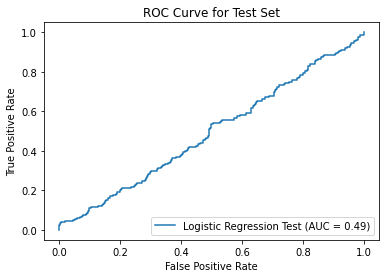

In [28]:
#!pip install scikit-learn matplotlib
from sklearn.metrics import roc_curve, auc
# Convert to Pandas DataFrame for evaluation and plotting
predictions_pd = predictions.toPandas()
y_test = predictions_pd['Potability']
y_proba_test = predictions_pd['probability'].apply(lambda x: x[1])


# Plot ROC curve
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, label='Logistic Regression Test (AUC = {:.2f})'.format(roc_auc_test))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Set')
plt.legend(loc='lower right')
plt.show()

# Decision tree

In [29]:
from pyspark.ml.classification import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
# Initialize and train the Decision Tree model
dt = DecisionTreeClassifier(labelCol="Potability", featuresCol="features")
dt_model = dt.fit(train)

# Make predictions
predictions = dt_model.transform(test)
predictions = predictions.select("Potability", "prediction")
evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Convert to Pandas DataFrame for evaluation
predictions_pd = predictions.toPandas()
y_test = predictions_pd['Potability']
y_pred_tree = predictions_pd['prediction']

# Evaluation using confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred_tree)
class_report = classification_report(y_test, y_pred_tree)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)
print("\nAccuracy:")
print(accuracy)     

Confusion Matrix:
[[271  79]
 [161  63]]

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.77      0.69       350
           1       0.44      0.28      0.34       224

    accuracy                           0.58       574
   macro avg       0.54      0.53      0.52       574
weighted avg       0.56      0.58      0.56       574


Accuracy:
0.5818815331010453


In [30]:
# Feature Importances
print("Feature Importances:")
for i, feature in enumerate(feature_columns):
    print(f"{feature}: {dt_model.featureImportances[i]}")
print("")

# Tree Depth
print(f"Tree Depth: {dt_model.depth}")

# Number of Leaves
print(f"Number of Leaves: {dt_model.numNodes}")

Feature Importances:
Solids_log: 0.1544017914951392
ph: 0.08798656642175555
Hardness: 0.1619910024071902
Chloramines: 0.25896191584062517
Conductivity: 0.049970353037891796
Organic_carbon: 0.08963053719351537
Trihalomethanes: 0.030744004017547746
Turbidity: 0.07234497922207432
pH_Category_index: 0.09396885036426063

Tree Depth: 5
Number of Leaves: 53


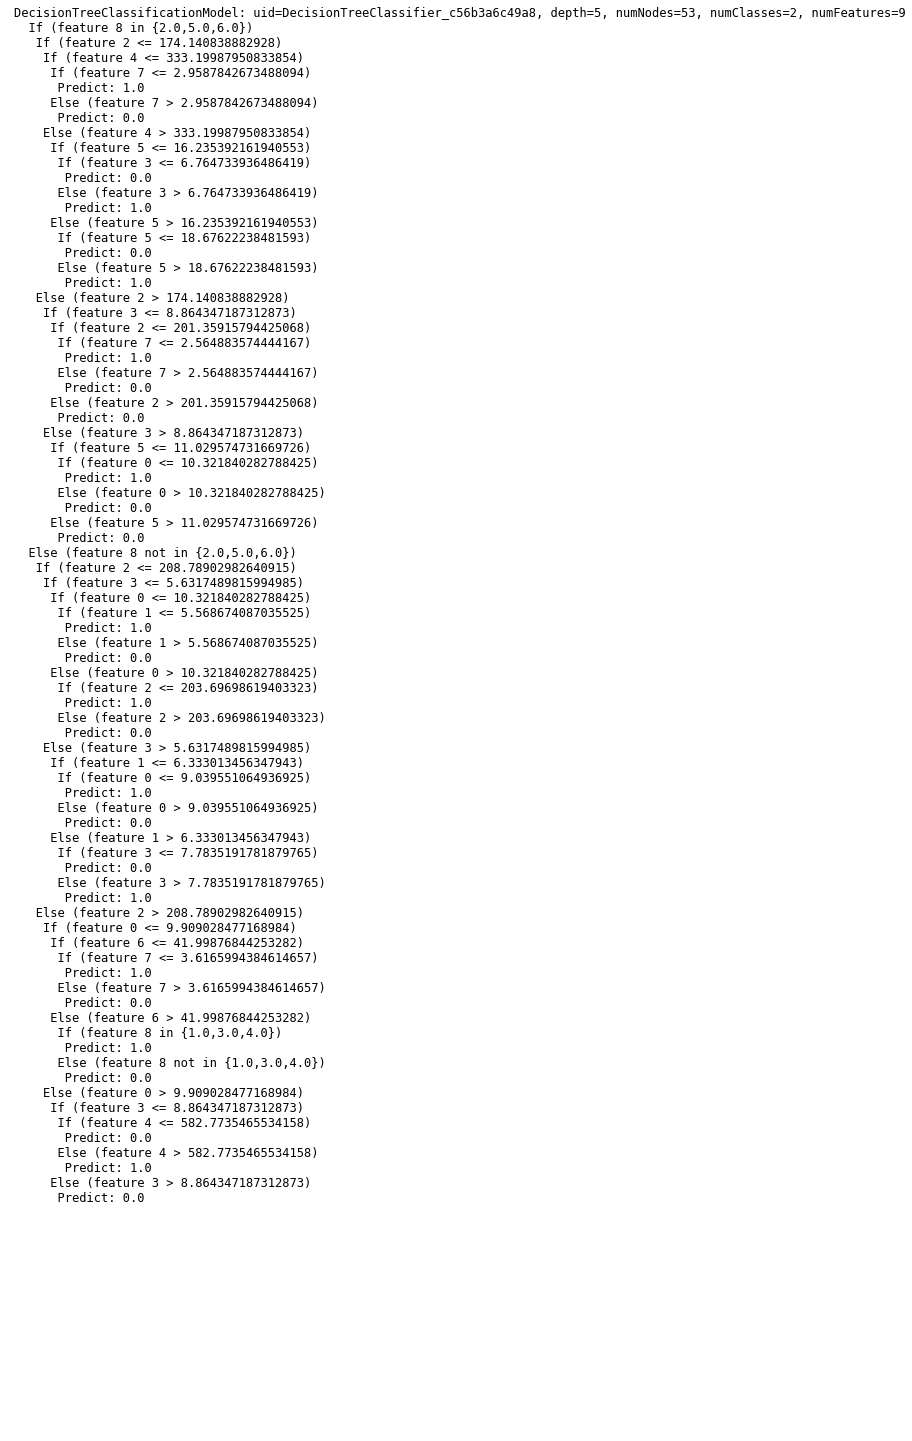

In [31]:
from sklearn.tree import export_text
import pydot
tree_text = dt_model.toDebugString

# Example: Simple text plot (you may want to parse and visualize more elegantly)
plt.figure(figsize=(12, 8))
plt.text(0.01, 0.5, tree_text, {'fontsize': 12}, fontproperties = 'monospace') 
plt.axis('off')
plt.show()

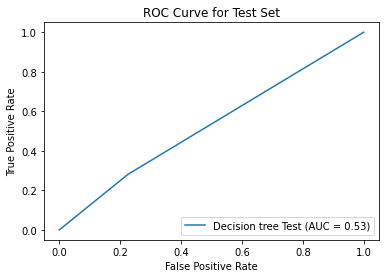

In [32]:
# Plot ROC curve
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_tree)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, label='Decision tree Test (AUC = {:.2f})'.format(roc_auc_test))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Set')
plt.legend(loc='lower right')
plt.show()

# Random forest

In [33]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="Potability", featuresCol="features", numTrees=100)
rf_model = rf.fit(train)

# Make predictions
predictions = rf_model.transform(test)
predictions = predictions.select("Potability", "prediction")

# Convert to Pandas DataFrame for evaluation
predictions_pd = predictions.toPandas()
evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")
y_test = predictions_pd['Potability']
y_pred_rf = predictions_pd['prediction']

# Evaluation using confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred_rf)
class_report = classification_report(y_test, y_pred_rf)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.6149825783972126
Confusion Matrix:
[[348   2]
 [219   5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.99      0.76       350
           1       0.71      0.02      0.04       224

    accuracy                           0.61       574
   macro avg       0.66      0.51      0.40       574
weighted avg       0.65      0.61      0.48       574



In [34]:
# Feature Importances
print("Feature Importances:")
for i, feature in enumerate(feature_columns):
    print(f"{feature}: {rf_model.featureImportances[i]}")
print("")

Feature Importances:
Solids_log: 0.127344027253472
ph: 0.1699877568793658
Hardness: 0.1409498800316351
Chloramines: 0.14825943085206494
Conductivity: 0.10054962973828468
Organic_carbon: 0.07513720614589817
Trihalomethanes: 0.07044648541478182
Turbidity: 0.07913966652866465
pH_Category_index: 0.08818591715583292



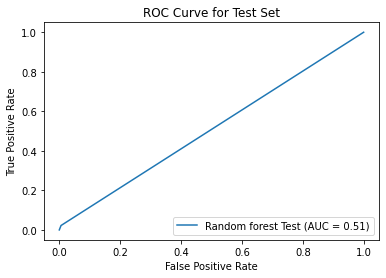

In [35]:
# Plot ROC curve
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_rf)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, label='Random forest Test (AUC = {:.2f})'.format(roc_auc_test))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Set')
plt.legend(loc='lower right')
plt.show()

# Neural networking 

In [36]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

layers = [len(feature_columns), 5, 4, 2]  

# Create the trainer and set its parameters
mlp = MultilayerPerceptronClassifier(labelCol="Potability", featuresCol="features", maxIter=100, layers=layers, blockSize=128, seed=42)

# Train the model
mlp_model = mlp.fit(train)

# Make predictions
predictions = mlp_model.transform(test)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# Get detailed classification report
evaluator_precision = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="f1")

precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1 = evaluator_f1.evaluate(predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.6097560975609756
Precision: 0.37180249851279
Recall: 0.6097560975609756
F1-score: 0.4619364375461936


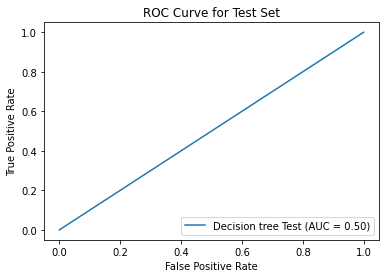

In [37]:
# Plot ROC curve
predictions = predictions.select("Potability", "prediction")

# Convert to Pandas DataFrame for evaluation
predictions_pd = predictions.toPandas()
y_test = predictions_pd['Potability']
y_pred_n = predictions_pd['prediction']

fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_n)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, label='Decision tree Test (AUC = {:.2f})'.format(roc_auc_test))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Set')
plt.legend(loc='lower right')
plt.show()

# LOGICAL TEST

Accuracy: 0.6076662908680946
Confusion Matrix:
[[532   2]
 [346   7]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      1.00      0.75       534
           1       0.78      0.02      0.04       353

    accuracy                           0.61       887
   macro avg       0.69      0.51      0.40       887
weighted avg       0.67      0.61      0.47       887



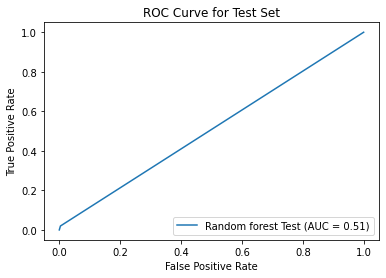

In [38]:
train, test = df.randomSplit([0.7, 0.3], seed=42)
rf = RandomForestClassifier(labelCol="Potability", featuresCol="features", numTrees=100)
rf_model = rf.fit(train)

# Make predictions
predictions = rf_model.transform(test)
predictions = predictions.select("Potability", "prediction")

# Convert to Pandas DataFrame for evaluation
predictions_pd = predictions.toPandas()
evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")
y_test = predictions_pd['Potability']
y_pred_rf = predictions_pd['prediction']

# Evaluation using confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred_rf)
class_report = classification_report(y_test, y_pred_rf)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_rf)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, label='Random forest Test (AUC = {:.2f})'.format(roc_auc_test))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Set')
plt.legend(loc='lower right')
plt.show()

# Parameters tunning

Accuracy: 0.6149825783972126
Confusion Matrix:
[[348   2]
 [219   5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.99      0.76       350
           1       0.71      0.02      0.04       224

    accuracy                           0.61       574
   macro avg       0.66      0.51      0.40       574
weighted avg       0.65      0.61      0.48       574



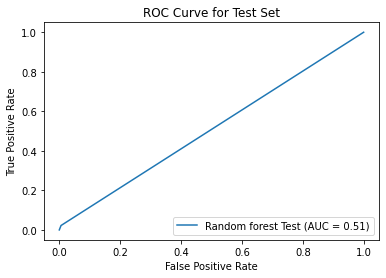

In [39]:
train, test = df.randomSplit([0.8, 0.2], seed=42)
rf = RandomForestClassifier(labelCol="Potability", featuresCol="features", numTrees=100)
rf_model = rf.fit(train)

# Make predictions
predictions = rf_model.transform(test)
predictions = predictions.select("Potability", "prediction")

# Convert to Pandas DataFrame for evaluation
predictions_pd = predictions.toPandas()
evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")
y_test = predictions_pd['Potability']
y_pred_rf = predictions_pd['prediction']

# Evaluation using confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred_rf)
class_report = classification_report(y_test, y_pred_rf)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_rf)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, label='Random forest Test (AUC = {:.2f})'.format(roc_auc_test))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Set')
plt.legend(loc='lower right')
plt.show()

In [40]:
# Feature Importances
print("Feature Importances:")
for i, feature in enumerate(feature_columns):
    print(f"{feature}: {rf_model.featureImportances[i]}")
print("")

Feature Importances:
Solids_log: 0.127344027253472
ph: 0.1699877568793658
Hardness: 0.1409498800316351
Chloramines: 0.14825943085206494
Conductivity: 0.10054962973828468
Organic_carbon: 0.07513720614589817
Trihalomethanes: 0.07044648541478182
Turbidity: 0.07913966652866465
pH_Category_index: 0.08818591715583292



In [41]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Create Random Forest model
rf = RandomForestClassifier(labelCol="Potability", featuresCol="features", numTrees=100)

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [5, 10, 20])
             .addGrid(rf.maxBins, [20, 40]) .build())

# Create 5-fold CrossValidator
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="Potability", 
                                                                      predictionCol="prediction", metricName="accuracy"),
                          numFolds=5)

# Run cross validations
cv_model = crossval.fit(train)

# Use the best model to make predictions
best_model = cv_model.bestModel
predictions = best_model.transform(test)
predictions = predictions.select("Potability", "prediction")

# Convert to Pandas DataFrame for further evaluation
predictions_pd = predictions.toPandas()
y_test = predictions_pd['Potability']
y_pred_rf = predictions_pd['prediction']

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Best Model Parameters: maxDepth={best_model.maxDepth}")
print(f"Accuracy: {accuracy}")

# Evaluation using confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred_rf)
class_report = classification_report(y_test, y_pred_rf)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

24/05/23 14:34:07 WARN DAGScheduler: Broadcasting large task binary with size 1356.2 KiB
24/05/23 14:34:08 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/05/23 14:34:09 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/05/23 14:34:10 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/05/23 14:34:11 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/05/23 14:34:13 WARN DAGScheduler: Broadcasting large task binary with size 1267.3 KiB
24/05/23 14:34:14 WARN DAGScheduler: Broadcasting large task binary with size 1880.1 KiB
24/05/23 14:34:15 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/05/23 14:34:16 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/23 14:34:17 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/23 14:34:19 WARN DAGScheduler: Broadcasting large task binary with size 1356.2 KiB
24/05/23 14:34:20 WARN DAGScheduler: Broad

24/05/23 14:36:09 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/05/23 14:36:11 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/05/23 14:36:12 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
24/05/23 14:36:13 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
24/05/23 14:36:15 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
24/05/23 14:36:16 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
24/05/23 14:36:17 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
24/05/23 14:36:18 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
24/05/23 14:36:19 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
24/05/23 14:36:21 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
24/05/23 14:36:23 WARN DAGScheduler: Broadcasting large task binary with size 1216.3 KiB
24/05/23 14:36:24 WARN DAGScheduler: Broadcasting l

24/05/23 14:38:12 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/05/23 14:38:13 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
24/05/23 14:38:15 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/05/23 14:38:16 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
24/05/23 14:38:18 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
24/05/23 14:38:19 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
24/05/23 14:38:20 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
24/05/23 14:38:21 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
24/05/23 14:38:22 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
24/05/23 14:38:24 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
24/05/23 14:38:27 WARN DAGScheduler: Broadcasting large task binary with size 1318.2 KiB
24/05/23 14:38:27 WARN DAGScheduler: Broadcasting l

Best Model Parameters: maxDepth=RandomForestClassifier_0067d73151fd__maxDepth
Accuracy: 0.6341463414634146
Confusion Matrix:
[[323  27]
 [183  41]]

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.92      0.75       350
           1       0.60      0.18      0.28       224

    accuracy                           0.63       574
   macro avg       0.62      0.55      0.52       574
weighted avg       0.62      0.63      0.57       574



24/05/23 14:38:32 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


In [42]:
# Feature Importances
print("Feature Importances:")
for i, feature in enumerate(feature_columns):
    print(f"{feature}: {rf_model.featureImportances[i]}")
print("")

Feature Importances:
Solids_log: 0.127344027253472
ph: 0.1699877568793658
Hardness: 0.1409498800316351
Chloramines: 0.14825943085206494
Conductivity: 0.10054962973828468
Organic_carbon: 0.07513720614589817
Trihalomethanes: 0.07044648541478182
Turbidity: 0.07913966652866465
pH_Category_index: 0.08818591715583292



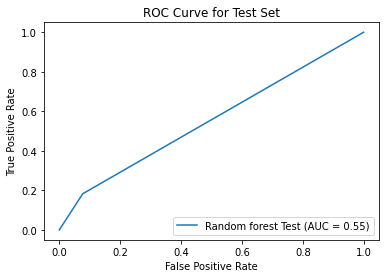

In [44]:
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_rf)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, label='Random forest Test (AUC = {:.2f})'.format(roc_auc_test))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Set')
plt.legend(loc='lower right')
plt.show()